In [1]:
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.core.dtypes.common import is_numeric_dtype
from sklearn.feature_selection import mutual_info_regression, f_regression, SelectKBest
from sklearn.preprocessing import MinMaxScaler

In [2]:
DATA_FOLDER = 'dataset'
IMAGE_FOLDER = 'images'
DATASET = os.path.join(DATA_FOLDER, 'outliers_removed.csv')

In [3]:
df = pd.read_csv(DATASET)

categorical_attr_list = [col for col in df.columns if not is_numeric_dtype(df[col])]

# one hot encoding
df_reg = df.drop(columns=categorical_attr_list)
df_reg = df_reg.join(pd.get_dummies(df[categorical_attr_list], columns=categorical_attr_list).astype(int))

df_reg.head()

,frame_count,sum,mean,std,min,max,q01,q05,q25,q75,...,actor_actor_24,actor_actor_3,actor_actor_4,actor_actor_5,actor_actor_6,actor_actor_7,actor_actor_8,actor_actor_9,sex_F,sex_M
0,158558,0.145081,9.150000e-07,0.004001,-0.038422,0.040588,-0.012586,-0.005890,-0.000031,0.0,...,0,0,0,0,0,0,0,0,0,1
1,160160,0.114319,7.137790e-07,0.004283,-0.042603,0.048157,-0.013550,-0.006104,-0.000031,0.0,...,0,0,0,0,0,0,0,0,0,1
2,156956,0.149963,9.554485e-07,0.005084,-0.037018,0.058472,-0.015822,-0.007294,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,1
3,152152,0.139618,9.176213e-07,0.004886,-0.036652,0.062683,-0.014923,-0.006714,-0.000031,0.0,...,0,0,0,0,0,0,0,0,0,1
4,169769,0.137665,8.108948e-07,0.002956,-0.026245,0.026215,-0.009399,-0.004364,-0.000031,0.0,...,0,0,0,0,0,0,0,0,0,1


In [4]:
features_to_correct = ['stft_min', 'sc_min']
(df[features_to_correct] < 0).any()

stft_min    False
sc_min      False
dtype: bool

# stft_min

In [5]:
TARGET = 'stft_min'

# drop quantile columns with high percentage of zeros (20%)
zero_percentage = (df_reg == 0).mean()
to_drop = [col for col in df_reg.columns if zero_percentage[col] > 0.2 and re.search(r'q\d{2}', col)]
to_drop.append('sc_min')
df_reg = df_reg.drop(columns=to_drop)
to_drop

['mfcc_q50',
 'sc_q01',
 'sc_q05',
 'stft_q01',
 'stft_q05',
 'mfcc_q25_w1',
 'mfcc_q50_w1',
 'sc_q01_w1',
 'sc_q05_w1',
 'sc_q25_w1',
 'stft_q05_w1',
 'q50_w2',
 'q50_w3',
 'lag1_q50_w3',
 'q75_w4',
 'sc_min']

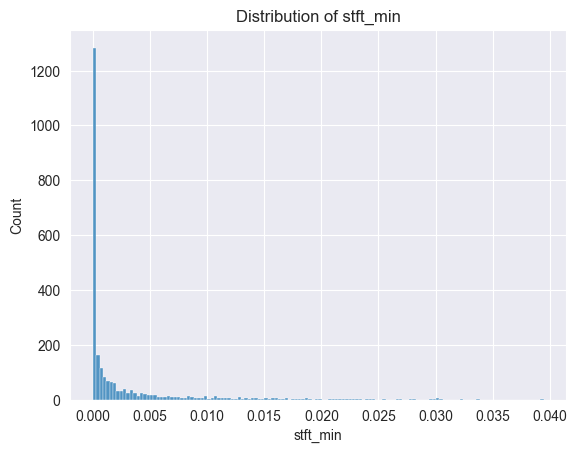

In [6]:
sns.histplot(data=df, x=df[TARGET])
plt.xlabel(f'{TARGET}')
plt.ylabel('Count')
plt.title(f'Distribution of {TARGET}')
plt.savefig(os.path.join(IMAGE_FOLDER, 'initial_stft_min_distr.pdf'), format='pdf')
plt.show()

In [7]:
from sklearn.model_selection import train_test_split

# rows to be fixed, do not reset indexes!
df_zero = df_reg[df_reg[TARGET] == 0]
df_nz = df_reg[df_reg[TARGET] != 0].reset_index(drop=True)

# dataframe has been one hot encoded
split_index = df_nz.index[df_nz['actor_actor_19'] == 1][0]

y_train = np.log10(df_nz[TARGET][:split_index].to_numpy())
y_test = np.log10(df_nz[TARGET][split_index+1:].to_numpy())

X_nz = df_nz.drop(columns=[TARGET]).to_numpy()
X_to_pred = df_zero.drop(columns=[TARGET]).to_numpy()

scaler = MinMaxScaler()
X_nz = scaler.fit_transform(X_nz)
X_to_pred = scaler.fit_transform(X_to_pred)

X_train = X_nz[:split_index]
X_test = X_nz[split_index+1:]

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=100)

print(X_train.shape, X_valid.shape, X_test.shape, X_to_pred.shape)

(846, 268) (212, 268) (360, 268) (1010, 268)


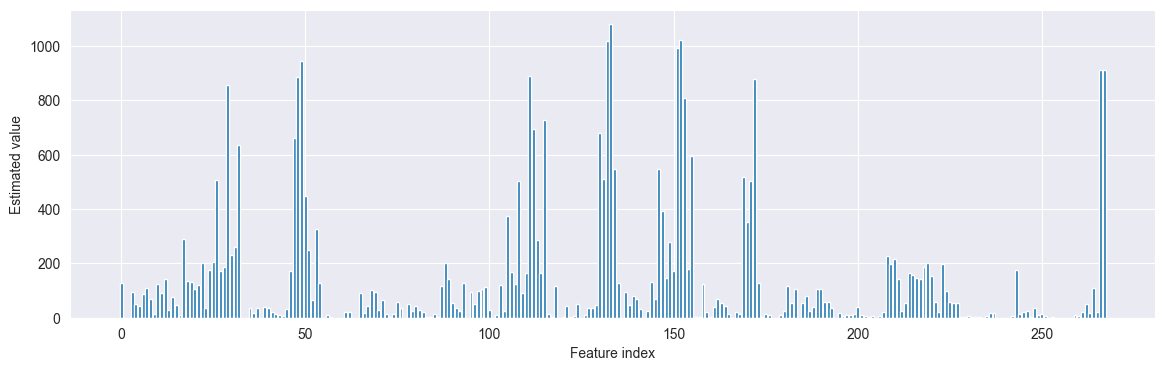

In [8]:
f_selector = SelectKBest(score_func=f_regression, k='all')
f_selector.fit(X_train, y_train)

plt.figure(figsize=(14, 4))
plt.bar([i for i in range(len(f_selector.scores_))], f_selector.scores_)
plt.xlabel('Feature index')
plt.ylabel('Estimated value')
plt.savefig(os.path.join(IMAGE_FOLDER, 'kbest_features_stft_min.pdf'), format='pdf')
plt.show()

In [9]:
f_selector = SelectKBest(score_func=f_regression, k=30)
f_selector.fit(X_train, y_train)

X_train = f_selector.transform(X_train)
X_valid = f_selector.transform(X_valid)
X_test = f_selector.transform(X_test)
X_to_pred = f_selector.transform(X_to_pred)

# selected columns
selected_indices = f_selector.get_support(indices=True)
df_nz.drop(columns=[TARGET]).iloc[:, selected_indices].columns

Index(['mfcc_max', 'mfcc_q25', 'mfcc_q99', 'stft_mean', 'stft_std', 'stft_q25',
       'stft_q50', 'stft_skew', 'mfcc_sum_w2', 'mfcc_max_w2', 'mfcc_q25_w2',
       'mfcc_q50_w2', 'mfcc_q99_w2', 'stft_sum_w2', 'stft_std_w2',
       'stft_q05_w2', 'stft_q25_w2', 'stft_skew_w2', 'mfcc_sum_w3',
       'mfcc_mean_w3', 'mfcc_q25_w3', 'mfcc_q50_w3', 'mfcc_q75_w3',
       'mfcc_q99_w3', 'stft_sum_w3', 'stft_std_w3', 'stft_q01_w3',
       'stft_q25_w3', 'sex_F', 'sex_M'],
      dtype='object')

## XGBoost

In [10]:
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import optuna

# objective function to be minimized
def objective_fun(trial):

    booster = trial.suggest_categorical('booster', ['gbtree', 'dart'])
    gamma = trial.suggest_float('gamma', 0, 5)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 3)
    subsample = trial.suggest_float('subsample', 0.4, 1)

    xgb = XGBRegressor(booster=booster, gamma=gamma, max_depth=max_depth, min_child_weight=min_child_weight, subsample=subsample)

    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_valid)

    error = mean_squared_error(y_valid, y_pred)

    return error


study = optuna.create_study()
study.optimize(objective_fun, n_trials=150, n_jobs=-1)

[I 2023-06-09 17:17:31,489] A new study created in memory with name: no-name-cdb03ab5-85ac-43d5-bf2a-271f1006dec6
[I 2023-06-09 17:17:31,956] Trial 7 finished with value: 0.07298703334310115 and parameters: {'booster': 'gbtree', 'gamma': 2.5895422246691675, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.5524528459732665}. Best is trial 7 with value: 0.07298703334310115.
[I 2023-06-09 17:17:31,967] Trial 4 finished with value: 0.07592620517187589 and parameters: {'booster': 'gbtree', 'gamma': 3.3531171463269067, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.70429483296679}. Best is trial 7 with value: 0.07298703334310115.
[I 2023-06-09 17:17:32,648] Trial 3 finished with value: 0.07665041779559252 and parameters: {'booster': 'gbtree', 'gamma': 3.9052824595721933, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.5678869369774332}. Best is trial 7 with value: 0.07298703334310115.
[I 2023-06-09 17:17:32,776] Trial 2 finished with value: 0.07360148011007467 and parameter

In [11]:
best_params = study.best_params

xgb = XGBRegressor(**best_params)
xgb.fit(X_train, y_train)

y_pred_test = xgb.predict(X_test)

print(best_params)
print('Root mean squared error = %.4f' % np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('R-squared = %.4f' % r2_score(y_test, y_pred_test))

{'booster': 'gbtree', 'gamma': 0.909975437435889, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.8947285554882192}
Root mean squared error = 0.2577
R-squared = 0.8546


In [12]:
y_pred = xgb.predict(X_to_pred)
y_pred = np.power(10, y_pred)
y_pred

array([1.5378723e-02, 1.4851452e-02, 8.8658873e-03, ..., 1.7166852e-04,
       1.4139709e-04, 8.8356603e-05], dtype=float32)

In [13]:
# negative values predicted
np.count_nonzero(y_pred < 0)

0

In [14]:
df_zero_xgb = df_zero.copy()
df_xgb = df.copy()

df_zero_xgb[TARGET] = y_pred
df_xgb.update(df_zero_xgb)

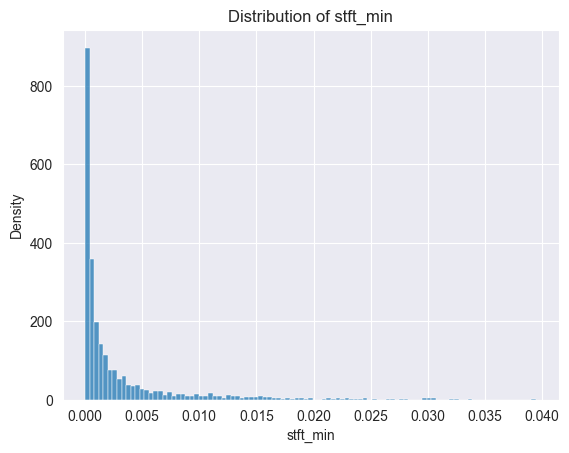

In [15]:
sns.histplot(data=df_xgb, x=TARGET, stat='density')
plt.xlabel(f'{TARGET}')
plt.ylabel('Density')
plt.title(f'Distribution of {TARGET}')
plt.savefig(os.path.join(IMAGE_FOLDER, 'xgboost_stft_min_distr.pdf'), format='pdf')
plt.show()

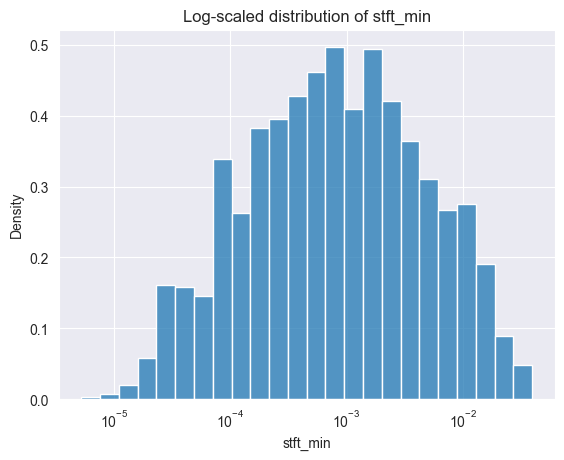

In [16]:
sns.histplot(data=df_xgb, x=TARGET, stat='density', log_scale=True)
plt.xlabel(f'{TARGET}')
plt.ylabel('Density')
plt.title(f'Log-scaled distribution of {TARGET}')
plt.savefig(os.path.join(IMAGE_FOLDER, 'xgboost_stft_min_logscale_distr.pdf'), format='pdf')
plt.show()

## Neural Network

In [17]:
import tensorflow
from keras import Sequential
from keras.layers import Dense

def create_model(trial):

    n_hidden = trial.suggest_int('n_hidden', 2, 5)
    n_units = trial.suggest_int('n_units', 32, 128)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1)

    model = Sequential()
    model.add(Dense(n_units, input_dim=X_train.shape[1], activation='relu'))

    for i in range(n_hidden):
        model.add(Dense(n_units, activation='relu'))

    model.add(Dense(1))
    model.compile(loss='mean_squared_error',
                  optimizer=tensorflow.keras.optimizers.legacy.Adam(learning_rate=learning_rate),
                  metrics=tensorflow.keras.metrics.MeanSquaredError())
    return model


# objective function to be minimized
def objective_fun(trial):

    model = create_model(trial)
    model.fit(X_train, y_train, epochs=30, batch_size=128, validation_data=(X_valid, y_valid), verbose=False)

    error = model.evaluate(X_valid, y_valid, verbose=False)[1]

    return error


study = optuna.create_study()
study.optimize(objective_fun, n_trials=150, n_jobs=-1)

[I 2023-06-09 17:18:28,986] A new study created in memory with name: no-name-858e1930-95b0-42d5-b8f7-6ae33d85cc2b


[I 2023-06-09 17:18:32,140] Trial 0 finished with value: 0.5828008055686951 and parameters: {'n_hidden': 3, 'n_units': 72, 'learning_rate': 0.09265192007939099}. Best is trial 0 with value: 0.5828008055686951.
[I 2023-06-09 17:18:32,151] Trial 6 finished with value: 0.09528473019599915 and parameters: {'n_hidden': 2, 'n_units': 65, 'learning_rate': 0.02026313886350761}. Best is trial 6 with value: 0.09528473019599915.
[I 2023-06-09 17:18:32,222] Trial 1 finished with value: 0.16456542909145355 and parameters: {'n_hidden': 2, 'n_units': 56, 'learning_rate': 0.052797008809721324}. Best is trial 6 with value: 0.09528473019599915.
[I 2023-06-09 17:18:32,224] Trial 2 finished with value: 0.09712916612625122 and parameters: {'n_hidden': 5, 'n_units': 61, 'learning_rate': 0.015255781430994436}. Best is trial 6 with value: 0.09528473019599915.
[I 2023-06-09 17:18:32,302] Trial 7 finished with value: 0.11783001571893692 and parameters: {'n_hidden': 3, 'n_units': 126, 'learning_rate': 0.08054278

In [18]:
study.best_params

{'n_hidden': 4, 'n_units': 126, 'learning_rate': 0.007694603593183715}

In [19]:
model = create_model(study.best_trial)
model.fit(X_train, y_train, epochs=30, batch_size=128, validation_data=(X_valid, y_valid), verbose=False)

y_pred_test = model.predict(X_test)

print('Root mean squared error = %.4f' % np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('R-squared = %.4f' % r2_score(y_test, y_pred_test))

12/12 [==============================] - 0s 439us/step
Root mean squared error = 0.3772
R-squared = 0.6882


In [20]:
y_pred = model.predict(X_to_pred)
y_pred = np.power(10, y_pred)
y_pred

32/32 [==============================] - 0s 455us/step


array([[1.1638735e-02],
       [1.2157449e-02],
       [9.2914021e-03],
       ...,
       [8.3272884e-05],
       [9.7056640e-05],
       [6.0952396e-05]], dtype=float32)

In [21]:
df_zero_ann = df_zero.copy()
df_ann = df.copy()

df_zero_ann[TARGET] = y_pred
df_ann.update(df_zero_ann)

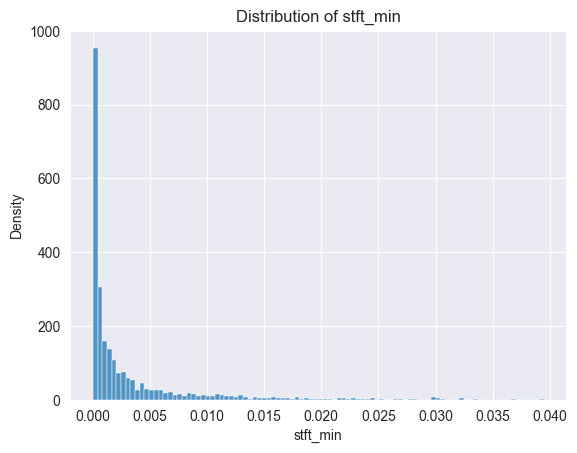

In [22]:
sns.histplot(data=df_ann, x=TARGET, stat='density')
plt.xlabel(f'{TARGET}')
plt.ylabel('Density')
plt.title(f'Distribution of {TARGET}')
plt.savefig(os.path.join(IMAGE_FOLDER, 'ann_stft_min_distr.pdf'), format='pdf')
plt.show()

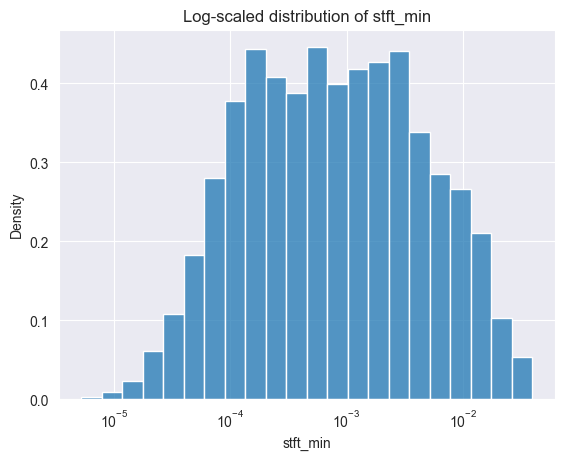

In [23]:
sns.histplot(data=df_ann, x=TARGET, stat='density', log_scale=True)
plt.xlabel(f'{TARGET}')
plt.ylabel('Density')
plt.title(f'Log-scaled distribution of {TARGET}')
plt.savefig(os.path.join(IMAGE_FOLDER, 'ann_stft_min_logscale_distr.pdf'), format='pdf')
plt.show()

In [29]:
pd.DataFrame(study.best_params, index=[0]).to_latex()

'\\begin{tabular}{lrrr}\n\\toprule\n & n_hidden & n_units & learning_rate \\\\\n\\midrule\n0 & 4 & 126 & 0.007695 \\\\\n\\bottomrule\n\\end{tabular}\n'